# Introduction

This code appears to be gathering and analyzing data from Twitter using the Twitter API and the SentimentIntensityAnalyzer from the Natural Language Toolkit (nltk).

The first block of code retrieves tweets containing the word "Cattle" (excluding retweets) and stores the tweet data in a JSON response object. It then converts the JSON response to a string and prints it.

The second block of code writes the tweet data to a CSV file with columns for the author ID, tweet ID, and tweet text.

The third block of code reads the CSV file, initializes the SentimentIntensityAnalyzer, and uses it to classify the sentiment of each tweet as positive, negative, or neutral. It then writes the resulting data to a new CSV file with columns for the author ID, tweet ID, tweet text, and polarity rating.

The fourth block of code reads the CSV file with the sentiment data and generates some plots using the Matplotlib library to visualize the distribution of sentiments.

The fifth block of code reads the CSV file with the sentiment data and generates a word cloud using the WordCloud library to show the most frequently occurring words in the tweet texts.

The sixth block of code reads the CSV file with the sentiment data and uses the TextBlob library to perform some further analysis on the tweet texts. It calculates the polarity and subjectivity of each tweet, as well as the overall average polarity and subjectivity of all the tweets. It also generates a pie chart to visualize the distribution of sentiments.

Finally, the seventh block of code generates a report on the sentiment analysis results, including the overall average polarity and subjectivity, the number of positive, negative, and neutral tweets, and the top five most frequently occurring words in the tweet texts.

In [192]:
#!pip install wordcloud

In [218]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from dotenv import dotenv_values
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import csv
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from keras.callbacks import EarlyStopping

config = dotenv_values(".env")

In [194]:
# Retrieve bearer token from config
bearer_token = config["BEARER_TOKEN"]

# Specify search endpoint for recent tweets
search_url = "https://api.twitter.com/2/tweets/search/recent" 

# Define query parameters for the search
query_params = {
    'query' : "\"grain prices\"", 
    'max_results' : '100',
    'tweet.fields': 'author_id',
}

# Set the necessary headers for the request
def bearer_oauth(r):
    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2RecentSearchPython"
    return r

# Send a request to the endpoint using the defined parameters 
def connect_to_endpoint(url, params):
    response = requests.get(url, auth=bearer_oauth, params=params)
   
    # Check the status code of the response
    print(response.status_code)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

# Query the API
json_response = connect_to_endpoint(search_url, query_params)

# Parse the response
parsedRes = json.dumps(json_response, indent=4, sort_keys=True, ensure_ascii=True) #ensure_ascii=False so non latin charaters and emojis wont so up
print(parsedRes)

200
{
    "data": [
        {
            "author_id": "1469685886484889611",
            "edit_history_tweet_ids": [
                "1609886482185031680"
            ],
            "id": "1609886482185031680",
            "text": "The method to the madness in Republican Ukraine policy.  Support Russia, grain prices rise, farmers raise prices, cost of food in the US rises, consumers are unhappy and they blame Democrats for food costs. https://t.co/s6VXzcCMQI"
        },
        {
            "author_id": "1334633996228169732",
            "edit_history_tweet_ids": [
                "1609708148796923905"
            ],
            "id": "1609708148796923905",
            "text": "@ByDonkeys Nothing to do with lockdown and the war in Ukraine then? Nothing to do with the fact that us not trading with Russia (rightly) has spiked grain prices?"
        },
        {
            "author_id": "218258733",
            "edit_history_tweet_ids": [
                "1609597751792177153"
          

This code is used to search for tweets on Twitter that mention "grain prices". The search is conducted through the Twitter API using a bearer token for authorization. The search parameters are specified in the query_params dictionary, which includes a query for "grain prices" and specifies the number of results and the fields to include in the response. The bearer_oauth function sets the authorization and user-agent headers in the request. The connect_to_endpoint function sends a GET request to the specified URL (the Twitter search API) with the specified query parameters and authorization headers. If the request is successful, the function returns the JSON response from the API. The parsed response is then printed to the console.

In [195]:
# similar as above just more detailed
import csv

# Extract the data from the response
data = json_response['data']

# Open a file for writing
with open('tweets.csv', 'w', newline='', encoding='utf-8') as csvfile:
    # Create a CSV writer
    writer = csv.writer(csvfile)
    
    # Write the header row
    writer.writerow(['Author ID', 'Tweet ID', 'Tweet Text'])
    
    # Write the data rows
    for tweet in data:
        author_id = tweet['author_id']
        tweet_id = tweet['id']
                         
# Extract the data from the response
data = json_response['data']

# Open a file for writing
with open('tweets.csv', 'w', newline='', encoding='utf-8') as csvfile:
    # Create a CSV writer
    writer = csv.writer(csvfile)

    # Write the header row
    writer.writerow(['Author ID', 'Tweet ID', 'Tweet Text'])

    # Write the data rows
    for tweet in data:
        author_id = tweet['author_id']
        tweet_id = tweet['id']
        if 'text' in tweet:
            tweet_text = tweet['text']
        else:
            tweet_text = ''
        writer.writerow([author_id, tweet_id, tweet_text])

Here we are extracting data from a JSON response and writing it to a CSV file. It first extracts the 'data' field from the JSON response and stores it in the variable 'data'. It then opens a file called 'tweets.csv' for writing, and creates a CSV writer to write to the file. It writes a header row to the CSV file with the fields 'Author ID', 'Tweet ID', and 'Tweet Text'. It then iterates over the 'data' list, extracting the 'author_id', 'id', and 'text' fields from each tweet. If the 'text' field is not present, it sets the tweet text to an empty string. Finally, it writes a row to the CSV file for each tweet, with the 'author_id', 'tweet_id', and 'tweet_text' as the values for each field.

In [219]:
# Download the VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')


# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Open the CSV file for reading
with open('tweets.csv', 'r', encoding='utf-8') as csvfile:
    # Create a CSV reader
    reader = csv.reader(csvfile)

    # Skip the header row
    next(reader)

    # Create an empty list to store the tweet data
    data = []
    
    # Iterate through the rows of the CSV file
    for row in reader:
        # Extract the tweet text
        tweet_text = row[2]

        # Use the SentimentIntensityAnalyzer to get the sentiment scores for the tweet
        scores = sia.polarity_scores(tweet_text)

         # Determine the polarity rating based on the compound score
        if scores['compound'] > 0:
            polarity_rating = 'Positive'
        elif scores['compound'] < 0:
            polarity_rating = 'Negative'
        else:
            polarity_rating = 'Neutral'

        # Add the tweet data and polarity rating to the list
        data.append([row[0], row[1], tweet_text, scores['compound'], polarity_rating])

        # Create a dataframe from the list of tweet data
        df = pd.DataFrame(data, columns=['Username', 'Date', 'Tweet', 'Compound Score', 'Polarity Rating'])


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\naomi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [197]:
df

,Username,Date,Tweet,Compound Score,Polarity Rating
0,1469685886484889611,1609886482185031680,The method to the madness in Republican Ukrain...,-0.6597,Negative
1,1334633996228169732,1609708148796923905,@ByDonkeys Nothing to do with lockdown and the...,-0.6440,Negative
2,218258733,1609597751792177153,@ByDonkeys Brexit. Nothing to do with increase...,0.2263,Positive
3,1584404438193647616,1609480928513908736,# Bank of America says Treasury-market liquidi...,-0.6249,Negative
4,1584361128972685312,1609427060316839936,# Boss of oil and gas giant says region may ha...,0.0000,Neutral
...,...,...,...,...,...
85,1460467516246052865,1607649373088776196,"bad harvests forced grain prices up, making la...",-0.9286,Negative
86,377185142,1607549449844178945,Farmers know they're only a bumper #crop or tw...,0.3400,Positive
87,2700538982,1607499134344495104,Sea transport in economic storms. UNCTAD 2022 ...,0.3182,Positive
88,1265623592,1607424719191425024,@MoreorLoess It is very likely that things are...,0.9092,Positive


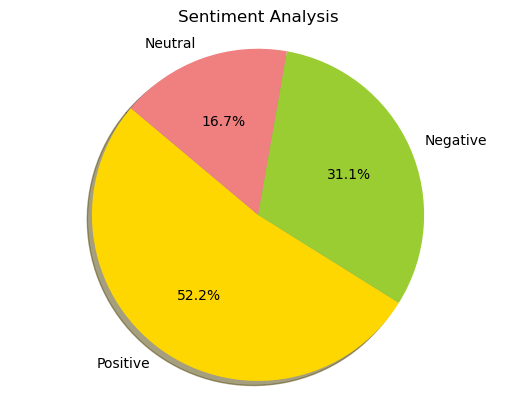

In [198]:
# Extract the data from the DataFrame
data = df['Polarity Rating']

# Initialize counters for the different sentiment categories
positive_count = 0
negative_count = 0
neutral_count = 0

# Iterate through the data and count the number of tweets in each sentiment category
for rating in data:
    if rating == 'Positive':
        positive_count += 1
    elif rating == 'Negative':
        negative_count += 1
    else:
        neutral_count += 1

# Create a list to store the data for the pie chart
pie_chart_data = [positive_count, negative_count, neutral_count]

# Set the labels and colors for the pie chart
labels = 'Positive', 'Negative', 'Neutral'
colors = ['gold', 'yellowgreen', 'lightcoral']

# Create the pie chart using the extracted data
plt.pie(pie_chart_data, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

# Add a title to the pie chart
plt.title('Sentiment Analysis')

# Make the pie chart equal axes
plt.axis('equal')

# Display the pie chart
plt.show()


In [199]:
# Print the shape of the dataframe
df.shape

(90, 5)

In [200]:
# Display the first few rows of the dataframe
df.head()

,Username,Date,Tweet,Compound Score,Polarity Rating
0,1469685886484889611,1609886482185031680,The method to the madness in Republican Ukrain...,-0.6597,Negative
1,1334633996228169732,1609708148796923905,@ByDonkeys Nothing to do with lockdown and the...,-0.6440,Negative
2,218258733,1609597751792177153,@ByDonkeys Brexit. Nothing to do with increase...,0.2263,Positive
3,1584404438193647616,1609480928513908736,# Bank of America says Treasury-market liquidi...,-0.6249,Negative
4,1584361128972685312,1609427060316839936,# Boss of oil and gas giant says region may ha...,0.0000,Neutral


In [201]:
# Define a function to remove a pattern of characters from a string
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
     
    return input_txt 

# Use the remove_pattern function to remove @ handles from the 'Tweet' column in the dataframe
df['Tweet'] = np.vectorize(remove_pattern)(df['Tweet'], "@[\w]*")

# Display the first few rows of the dataframe after removing @ handles
df.head()

,Username,Date,Tweet,Compound Score,Polarity Rating
0,1469685886484889611,1609886482185031680,The method to the madness in Republican Ukrain...,-0.6597,Negative
1,1334633996228169732,1609708148796923905,Nothing to do with lockdown and the war in Uk...,-0.6440,Negative
2,218258733,1609597751792177153,Brexit. Nothing to do with increase in grain ...,0.2263,Positive
3,1584404438193647616,1609480928513908736,# Bank of America says Treasury-market liquidi...,-0.6249,Negative
4,1584361128972685312,1609427060316839936,# Boss of oil and gas giant says region may ha...,0.0000,Neutral


In [202]:
# Display the 'Tweet' column after removing @ handles
df['Tweet'].head()

0    The method to the madness in Republican Ukrain...
1     Nothing to do with lockdown and the war in Uk...
2     Brexit. Nothing to do with increase in grain ...
3    # Bank of America says Treasury-market liquidi...
4    # Boss of oil and gas giant says region may ha...
Name: Tweet, dtype: object

In [203]:
# Create an empty list to store the cleaned tweets
corpus = []

# Iterate over the rows of the dataframe
for i in range(0, 91):
    # Check if the index exists in the dataframe
    if i in df.index:
        # Remove non-alphanumeric characters, convert to lowercase, and remove 'rt' and URLs
        tweet = re.sub('[^a-zA-Z0-9]', ' ', df['Tweet'][i])
        tweet = tweet.lower()
        tweet = re.sub('rt', '', tweet)
        # Perform other processing on the tweet
    tweet = re.sub('http', '', tweet)
    tweet = re.sub('https', '', tweet)
    # Stem the cleaned tweets using the Porter stemmer
    tweet = tweet.split()
    ps = PorterStemmer()
    tweet = [ps.stem(word) for word in tweet if not word in set(stopwords.words('english'))]
    
    # Join the stemmed words back into a single string
    tweet = ' '.join(tweet)
    
    # Add the cleaned tweet to the corpus
    corpus.append(tweet)

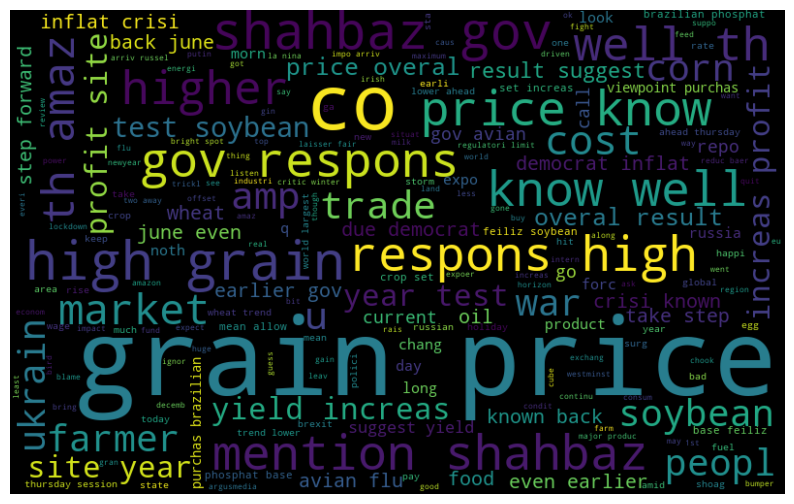

In [204]:
# Generate a word cloud from all the tweets in the corpus
all_words = ' '.join([text for text in corpus])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

# Display the word cloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [205]:
# Create a TfidfVectorizer to generate a tf-idf representation of the tweets
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df['Tweet'])

# Count the most frequent words in the corpus
Counter = Counter(corpus)
most_occur = Counter.most_common(10) 
print(most_occur)

[('amaz would mention shahbaz gov respons high grain price know well th', 12), ('yield increas profit 2 site year test soybean grain price overal result suggest', 6), ('avian flu grain price due democrat inflat crisi known back june 2022 even earlier gov', 5), ('viewpoint purchas brazilian phosphat base feiliz 2022 23 soybean crop set increas', 2), ('laisser fair mean allow irish farmer get maximum price expo intern mean allow expo critic 46 47 winter grain price high impo arriv russel bc pm', 2), ('method mad republican ukrain polici suppo russia grain price rise farmer rais price cost food us rise consum unhappi blame democrat food cost co s6vxzccmqi', 1), ('noth lockdown war ukrain noth fact us trade russia rightli spike grain price', 1), ('brexit noth increas grain price result ukrain war trickl price food noth increas energi price trickl everyth brexit', 1), ('bank america say treasuri market liquid stress singl largest system financi risk today world largest wheat exchang trade f

In [206]:
# Check DataFrame
df

,Username,Date,Tweet,Compound Score,Polarity Rating
0,1469685886484889611,1609886482185031680,The method to the madness in Republican Ukrain...,-0.6597,Negative
1,1334633996228169732,1609708148796923905,Nothing to do with lockdown and the war in Uk...,-0.6440,Negative
2,218258733,1609597751792177153,Brexit. Nothing to do with increase in grain ...,0.2263,Positive
3,1584404438193647616,1609480928513908736,# Bank of America says Treasury-market liquidi...,-0.6249,Negative
4,1584361128972685312,1609427060316839936,# Boss of oil and gas giant says region may ha...,0.0000,Neutral
...,...,...,...,...,...
85,1460467516246052865,1607649373088776196,"bad harvests forced grain prices up, making la...",-0.9286,Negative
86,377185142,1607549449844178945,Farmers know they're only a bumper #crop or tw...,0.3400,Positive
87,2700538982,1607499134344495104,Sea transport in economic storms. UNCTAD 2022 ...,0.3182,Positive
88,1265623592,1607424719191425024,"It is very likely that things are frothy, but...",0.9092,Positive


Removing the 'Username', 'Date', and 'Compound Score' columns from a dataframe called 'df'.

Using the 'get_dummies' function from pandas to one-hot encode the 'Polarity Rating' column in 'df'.

Removing the 'Polarity Rating' column from 'df' and concatenating the one-hot encoded version of it back onto 'df'.

Splitting the data in 'df' into input features (stored in 'X') and labels (stored in 'y').

Splitting 'X' and 'y' into training and test sets using the 'train_test_split' function from scikit-learn.

Using the 'CountVectorizer' from scikit-learn to vectorize the training set, and then transforming the test set to match the same vocabulary.

Using the 'TfidfTransformer' from scikit-learn to transform the vectorized training and test sets into tf-idf representations.

Converting the tf-idf representations of the training and test sets into NumPy arrays.

Defining a Sequential model with four densely connected layers and 'relu' activation functions, followed by a 'softmax' activation function in the output layer.

Compiling the model with the 'Adam' optimizer, 'categorical_crossentropy' loss function, and 'accuracy' metric.

Training the model using the 'fit' method, with an 'EarlyStopping' callback to interrupt training if the validation loss does not improve after a certain number of epochs.

Evaluating the model on the test set and printing the test accuracy.

Using the model to make predictions on the test set and storing the predictions in 'preds'.

WHY

It appears that the purpose of this code is to build and train a machine learning model for sentiment analysis on some text data. The model is a neural network with four densely connected layers, and it is trained using a categorical cross-entropy loss function and an Adam optimizer.

The model is trained on a dataset where the input features are tweets and the labels are the corresponding sentiment labels (positive, negative, or neutral). The model is then evaluated on a separate test set to measure its performance.

After training, the model can be used to predict the sentiment of new tweets that it has not seen before.

In [207]:
# Remove certain columns from the dataframe
df = df.drop(columns=['Username', 'Date', 'Compound Score'])

In [208]:
# Check DataFrame
df

,Tweet,Polarity Rating
0,The method to the madness in Republican Ukrain...,Negative
1,Nothing to do with lockdown and the war in Uk...,Negative
2,Brexit. Nothing to do with increase in grain ...,Positive
3,# Bank of America says Treasury-market liquidi...,Negative
4,# Boss of oil and gas giant says region may ha...,Neutral
...,...,...
85,"bad harvests forced grain prices up, making la...",Negative
86,Farmers know they're only a bumper #crop or tw...,Positive
87,Sea transport in economic storms. UNCTAD 2022 ...,Positive
88,"It is very likely that things are frothy, but...",Positive


In [209]:
# Create one-hot encoded columns for the 'Polarity Rating' column
one_hot = pd.get_dummies(df["Polarity Rating"])

# Drop the 'Polarity Rating' column and concatenate the one-hot encoded columns
df.drop(['Polarity Rating'],axis=1,inplace=True)
df = pd.concat([df,one_hot],axis=1)

# Display the modified dataframe
df.head()

,Tweet,Negative,Neutral,Positive
0,The method to the madness in Republican Ukrain...,1,0,0
1,Nothing to do with lockdown and the war in Uk...,1,0,0
2,Brexit. Nothing to do with increase in grain ...,0,0,1
3,# Bank of America says Treasury-market liquidi...,1,0,0
4,# Boss of oil and gas giant says region may ha...,0,1,0


In [210]:
# Split the data into input features (X) and labels (y)
X = df['Tweet'].values
y = df.drop('Tweet', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [211]:
# Convert the input features to a bag-of-words representation
vect = CountVectorizer()
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

In [212]:
# Convert the bag-of-words representation to a tf-idf representation
tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

# Convert the tf-idf representation to a dense array
X_train = X_train.toarray()
X_test = X_test.toarray()

In [213]:
# Create a Sequential model
model = Sequential()

# Add four densely connected layers to the model
model.add(Dense(units=12673,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=4000,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=500,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=3, activation='softmax'))

# Use the Adam optimizer with a learning rate of 0.001
opt=tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model with the 'categorical_crossentropy' loss function and the Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [214]:
# Create an EarlyStopping callback to stop training when the validation loss stops improving
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Fit the model using training data and the EarlyStopping callback
model.fit(x=X_train, y=y_train, batch_size=256, epochs=100, validation_data=(X_test, y_test), verbose=1, 
          callbacks=early_stop)

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 1.0923 - accuracy: 0.4286 - val_loss: 0.9415 - val_accuracy: 0.5185
Epoch 2/100
1/1 [==============================] - 1s 737ms/step - loss: 0.9177 - accuracy: 0.5238 - val_loss: 0.8767 - val_accuracy: 0.5185
Epoch 3/100
1/1 [==============================] - 1s 736ms/step - loss: 0.7974 - accuracy: 0.5238 - val_loss: 0.6942 - val_accuracy: 0.6667
Epoch 4/100
1/1 [==============================] - 1s 723ms/step - loss: 0.5683 - accuracy: 0.8254 - val_loss: 0.5861 - val_accuracy: 0.7407
Epoch 5/100
1/1 [==============================] - 1s 663ms/step - loss: 0.3270 - accuracy: 0.9683 - val_loss: 0.6269 - val_accuracy: 0.6296
Epoch 6/100
1/1 [==============================] - 1s 645ms/step - loss: 0.1848 - accuracy: 1.0000 - val_loss: 0.6757 - val_accuracy: 0.6296
Epoch 7/100
1/1 [==============================] - 1s 741ms/step - loss: 0.0819 - accuracy: 0.9841 - val_loss: 0.7251 - val_accuracy: 0.7037
Epoch 8/100
1/1 

In [215]:
# Evaluate the model's performance on the test data
model_score = model.evaluate(X_test, y_test, batch_size=64, verbose=1)
print('Test accuracy:', model_score[1])

1/1 [==============================] - 0s 76ms/step - loss: 0.9775 - accuracy: 0.6667
Test accuracy: 0.6666666865348816


In [216]:
# Make predictions using the model
preds = model.predict(X_test)
preds

1/1 [==============================] - 0s 97ms/step


array([[1.6571546e-10, 6.6257786e-07, 9.9999928e-01],
       [1.6097417e-01, 8.0512345e-01, 3.3902358e-02],
       [8.1432496e-05, 9.9913353e-01, 7.8502949e-04],
       [5.9925420e-09, 2.2260338e-05, 9.9997771e-01],
       [3.5371599e-01, 5.8752831e-02, 5.8753115e-01],
       [7.1271253e-11, 3.3621866e-06, 9.9999666e-01],
       [1.6368923e-01, 1.5863603e-01, 6.7767477e-01],
       [2.5039417e-09, 4.6140945e-06, 9.9999535e-01],
       [9.9999964e-01, 2.1965668e-07, 1.5557198e-07],
       [2.1659459e-01, 3.2356119e-01, 4.5984423e-01],
       [5.0667118e-15, 7.9805204e-11, 1.0000000e+00],
       [8.3386123e-01, 6.4159065e-02, 1.0197976e-01],
       [3.6207555e-04, 9.9811184e-01, 1.5260569e-03],
       [2.6466450e-08, 2.8842758e-05, 9.9997115e-01],
       [3.2321776e-03, 2.3602758e-01, 7.6074022e-01],
       [9.9377233e-01, 1.4438501e-03, 4.7837878e-03],
       [2.7241132e-01, 5.5099793e-02, 6.7248887e-01],
       [7.1401399e-01, 4.3710802e-02, 2.4227516e-01],
       [8.7496316e-01, 5.783

In [217]:
# Checking the dimensions of the predictions array
preds.shape

(27, 3)

## References

1. https://analyticsindiamag.com/hands-on-guide-to-download-analyze-and-visualize-twitter-data/